In [1]:
import pickle as pkl
import time
import os
import numpy as np
import sys
#from music21 import instrument, note, stream, chord, duration
#from models.RNNAttention import create_network, sample_with_temp

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras.utils import np_utils
from keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from keras.layers import Multiply, Lambda, Softmax
import keras.backend as K 
from keras.models import Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


# parameters

In [2]:
# run params
section = 'composetxt'
run_id = '0001'
txt_name = 'txtattn'

run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, txt_name])

# model params
embed_size = 100
rnn_units = 256
use_attention = True

## load the lookup tables

In [3]:

store_folder = os.path.join(run_folder, 'store')


## build the model

In [4]:
def create_network(n_tokens, embed_size = 100, rnn_units = 256, use_attention = False):
    """ create the structure of the neural network """

    text_in = Input(shape = (None,))

    x1 = Embedding(n_tokens, embed_size)(text_in) # embed tokens, for each of text tokens coming in

    #x = Concatenate()([x1,x2])
    x = x1 # todo: remove and change x1

    x = LSTM(rnn_units, return_sequences=True)(x)
    # x = Dropout(0.2)(x)

    if use_attention:

        x = LSTM(rnn_units, return_sequences=True)(x)
        # x = Dropout(0.2)(x)

        e = Dense(1, activation='tanh')(x) # dense layer with one output
        e = Reshape([-1])(e) # squash output to a single vector, length of input sequence seq_length
        alpha = Activation('softmax')(e) # weights calculated through softmax

        alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha)) # forms matrix [rnn_units][seq_length], permute to transpose

        c = Multiply()([x, alpha_repeated])
        c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
    else:
        c = LSTM(rnn_units)(x)
        # c = Dropout(0.2)(c)
                                    
    text_out = Dense(n_tokens, activation = 'softmax', name = 'text')(c)
   
    model = Model(text_in, text_out)

    if use_attention:
        att_model = Model(text_in, alpha) # outputs alpha layer vector to see attention at work
    else:
        att_model = None

    opti = RMSprop(lr = 0.001)
    model.compile(loss=['categorical_crossentropy'], optimizer=opti)

    return model, att_model

In [5]:
import re

token_type = 'word'

#load in the text and perform some cleanup

seq_length = 20

filename = "./data/aesop/data.txt"

with open(filename, encoding='utf-8-sig') as f:
    text = f.read()    
    
#removing text before and after the main stories
start = text.find("THE FOX AND THE GRAPES\n\n\n")
end = text.find("ILLUSTRATIONS\n\n\n[")
text = text[start:end]

start_story = '| ' * seq_length
    
text = start_story + text
text = text.lower()
text = text.replace('\n\n\n\n\n', start_story)
text = text.replace('\n', ' ')
text = re.sub('  +', '. ', text).strip()
text = text.replace('..', '.')

text = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~])', r' \1 ', text)
text = re.sub('\s{2,}', ' ', text)

len(text)

213694

In [6]:
from keras.preprocessing.text import Tokenizer

if token_type == 'word':
    tokenizer = Tokenizer(char_level = False, filters = '')
else:
    tokenizer = Tokenizer(char_level = True, filters = '', lower = False)    
    
tokenizer.fit_on_texts([text])

total_words = len(tokenizer.word_index) + 1

token_list = tokenizer.texts_to_sequences([text])[0]

print(total_words)

print(str(tokenizer.word_index)[0:50]) # vocabulary
print(token_list[:50]) # tokenized text

4170
{'|': 1, ',': 2, 'the': 3, 'and': 4, '.': 5, 'a': 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 56, 4, 3, 940, 5, 6, 382, 56, 94, 77, 216, 1557, 9, 940, 941, 62, 6, 581, 20, 12, 2226, 162, 6, 359, 2227, 2, 4, 158, 11]


In [7]:
weights_folder = os.path.join(run_folder, 'weights')
weights_file = 'weights.h5'

#model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model, att_model = create_network(len(tokenizer.word_index)+1, embed_size, rnn_units, use_attention)

# Load the weights to each node
weight_source = os.path.join(weights_folder,weights_file)
model.load_weights(weight_source)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    417000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 256)    365568      embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 256)    525312      lstm_1[0][0]                     
____________________________________________________________________________________________

## build your own phrase

In [8]:
# prediction params
text_temp=0.8
max_extra_text = 150 # 50
max_seq_len = 32
seq_len = 32

# init text and translate input text to tokens
text_init = ['START', 'this', 'run', 'lion', 'first', 'test', 'the', 'fox', 'jumped']
token_seq = tokenizer.texts_to_sequences([text_init])[0] # todo: what if new tokens in init sequence?

#if seq_len is not None:
    #text_init = ['START'] * (seq_len - len(token_seq)) + token_seq

sequence_length = len(text_init)

print(token_seq)
print(text_init)

[1076, 74, 422, 52, 185, 1819, 3, 56, 1033]
['START', 'this', 'run', 'lion', 'first', 'test', 'the', 'fox', 'jumped']


## Generate text from the neural network based on a sequence of words

We will generate tokens and translate the tokens back to words after generation

In [9]:
def sample_with_temp(preds, temperature):
    '''simulated annealing'''
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature # predictions passed through the alignment function
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds) # softmax
        return np.random.choice(len(preds), p=preds)

In [10]:
import tensorflow as tf

prediction_output = []
text_input_sequence = []

overall_preds = []

#for n, d in zip(notes, durations):
#for tkn in text_init:
for tkn in token_seq:
    #text_int = text_to_int[tkn]
    
    #if tkn != 'START':
    #text_input_sequence.append(tokenizer.texts_to_sequences([tkn])[0])
    #prediction_output.append([tkn])
    text_input_sequence.append(tkn)
    new_text = np.zeros(128)
    overall_preds.append(new_text)
    '''else:
        text_input_sequence.append([0])
        prediction_output.append([0])'''
        
print(text_input_sequence)

att_matrix = np.zeros(shape = (max_extra_text + sequence_length, max_extra_text))

# carefult with tf memory: consumes all GPU memory, do not run 2+ tf instances
'''gpus = tf.config.experimental.list_physical_devices('GPU') # added from https://stackoverflow.com/questions/57062456/function-call-stack-keras-scratch-graph-error
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)'''

for text_index in range(max_extra_text):

    prediction_input = np.array([text_input_sequence]) # text_input_sequence grows with predicted next token (has to be [])
    #print('prediction_input: ', prediction_input[:30])
    text_prediction = model.predict(prediction_input, verbose=0)
    #print('text prediction: ', text_prediction[:30])
    if use_attention:
        att_prediction = att_model.predict(prediction_input, verbose=0)[0]
        #print(text_index, len(att_prediction), sequence_length)
        att_matrix[(text_index-len(att_prediction)+sequence_length):(text_index+sequence_length), text_index] = att_prediction
    
    new_text = np.zeros(128)
    
    for idx, n_i in enumerate(text_prediction[0]):
        try:
            new_text[idx] = n_i
        except:
            pass
    #nex_text = [tok for tok in text_prediction[0]]
    #print('new text: ', new_text)
    overall_preds.append(new_text)
    i1 = sample_with_temp(text_prediction[0], text_temp) # returns sample token
    
    #print('i1: ', i1)
    #note_result = int_to_note[i1]
    #print(tokenizer.sequences_to_texts([[i1]]))
    text_result = tokenizer.sequences_to_texts([[i1]])
    prediction_output.append([text_result])
    #text_input_sequence.append([i1]) # append sampled token to input sequence
    text_input_sequence.append(i1)
    
    if len(text_input_sequence) > max_seq_len:
        text_input_sequence = text_input_sequence[1:]
        
#     print(note_result)
#     print(duration_result)
        
    if text_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds)) 
print('Generated sequence of {} tokens'.format(len(prediction_output)))

[1076, 74, 422, 52, 185, 1819, 3, 56, 1033]
Generated sequence of 150 tokens


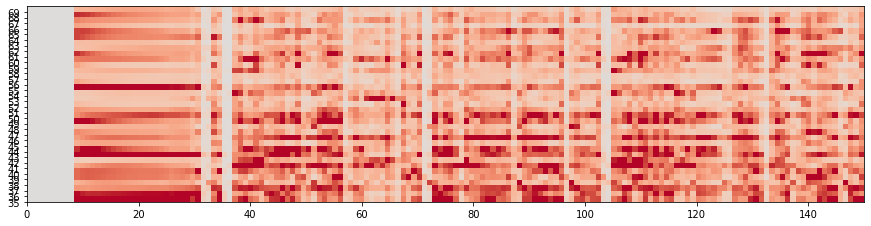

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_yticks([int(j) for j in range(35,70)])

plt.imshow(overall_preds[35:70,:], origin="lower", cmap='coolwarm', vmin = -0.01, vmax = 0.01, extent=[0, max_extra_text, 35,70]
          
          )

In [12]:
print(overall_preds)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.57726492e-06
  4.21498771e-06 5.51325184e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.30206207e-03
  1.03432103e-03 1.38031179e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.97523295e-03
  4.82567446e-03 2.19817739e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.88395381e-03
  9.97026567e-04 1.65900984e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.19255500e-03
  1.67614024e-03 3.14671989e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.30194775e-03
  9.16081073e-04 1.39956269e-03]]


In [13]:
print(prediction_output)

[[['no']], [['their']], [['away']], [['got']], [['into']], [['this']], [['long']], [['out']], [['-']], [['use']], [['take']], [['it']], [['of']], [['and']], [['like']], [['frightened']], [['why']], [[':']], [['their']], [['to']], [['into']], [['up']], [['it']], [['come']], [[',']], [['he']], [['then']], [['said']], [[',']], [['"']], [['how']], [['fox']], [[',']], [['his']], [['what']], [['miller']], [['from']], [['we']], [['how']], [['out']], [['in']], [['the']], [['head']], [['back']], [[',']], [['and']], [['we']], [['a']], [['my']], [['at']], [['up']], [['.']], [['"']], [['get']], [[',']], [['!']], [['"']], [[',']], [['good']], [['while']], [['said']], [['the']], [['turned']], [['of']], [['the']], [['teeth']], [[',']], [['and']], [['him']], [['and']], [['and']], [['governor']], [['.']], [['just']], [[',']], [['"']], [['good']], [['will']], [['and']], [['way']], [['in']], [['an']], [['reason']], [[',']], [['and']], [['her']], [['all']], [['as']], [['as']], [['me']], [['but']], [['the'

## convert the output from the prediction from tokens to words

In [14]:
output_folder = os.path.join(run_folder, 'output')

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    #note_pattern, duration_pattern = pattern
    text_pattern = pattern



timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write('midi', fp=os.path.join(output_folder, 'output-' + timestr + '.mid'))

NameError: name 'midi_stream' is not defined

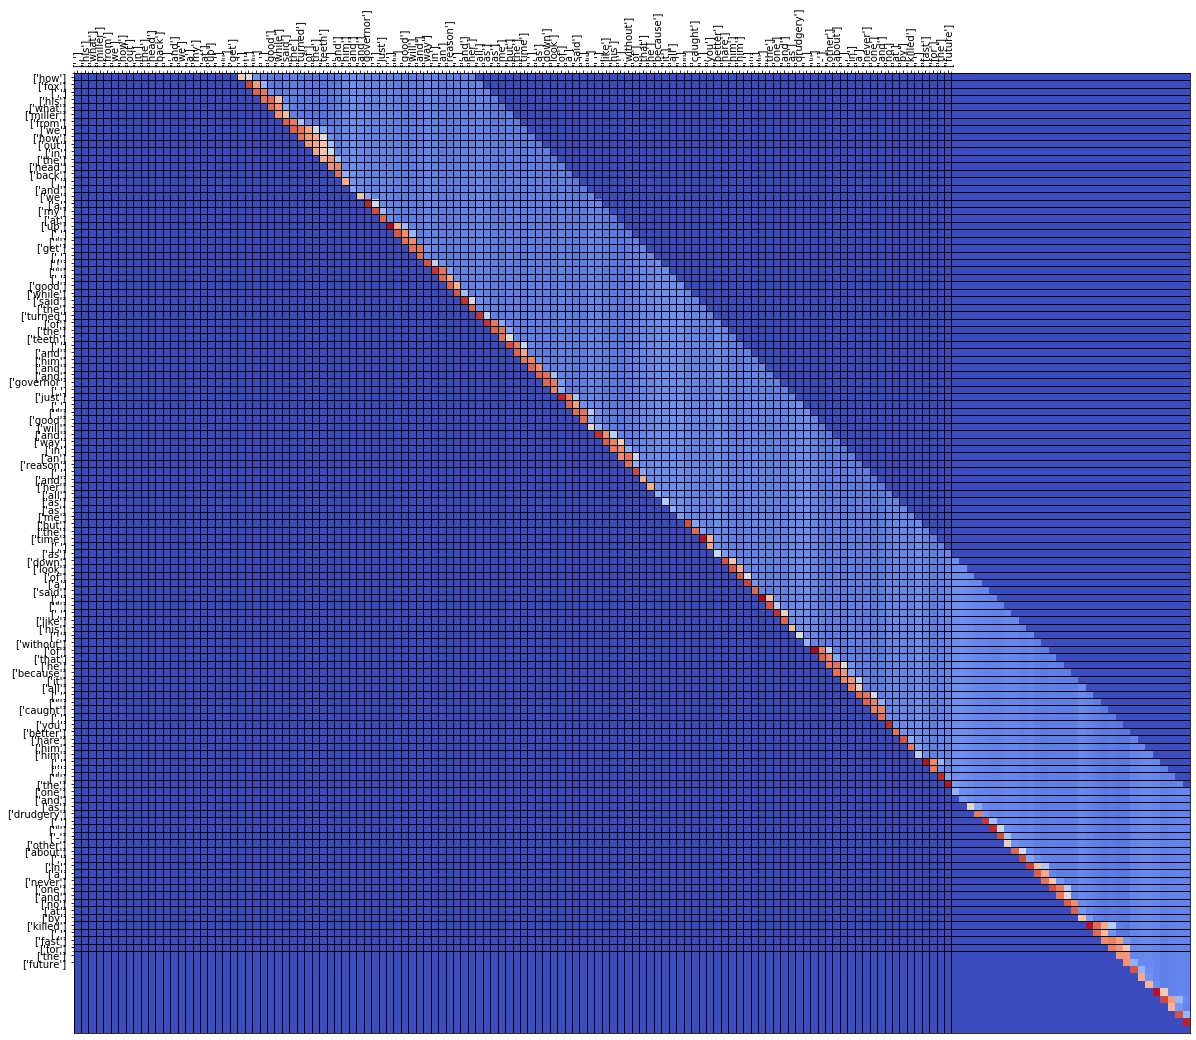

In [15]:
## attention plot
if use_attention:
    fig, ax = plt.subplots(figsize=(20,20))

    im = ax.imshow(att_matrix[(seq_len-2):,], cmap='coolwarm', interpolation='nearest')
    

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)  
    
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(prediction_output) - seq_len))
    ax.set_yticks(np.arange(len(prediction_output)- seq_len+2))
    # ... and label them with the respective list entries
    ax.set_xticklabels([n[0] for n in prediction_output[(seq_len):]])
    ax.set_yticklabels([n[0] for n in prediction_output[(seq_len - 2):]])

    # ax.grid(color='black', linestyle='-', linewidth=1)

    ax.xaxis.tick_top()

    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
             rotation_mode="anchor")

    plt.show()

In [16]:
print(att_matrix)

[[0.11309944 0.10182551 0.09259766 ... 0.         0.         0.        ]
 [0.11163473 0.10050681 0.09139846 ... 0.         0.         0.        ]
 [0.11104327 0.09997431 0.09091422 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.17186631 0.05233202]
 [0.         0.         0.         ... 0.         0.         0.18639414]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [24]:
# pair of max attention tokens
result = np.where(att_matrix == np.amax(att_matrix))
print(prediction_output[result[0][0]], prediction_output[result[1][0]])

[[',']] [['time']]


In [38]:
# token paths along maximum attention
init_token = 22 # initial index of first token to start path
print(prediction_output[init_token])
# generated along x-axis
result = np.where(att_matrix == np.amax(att_matrix, axis=0)) # max along every column
print('y: ', result[0][init_token]) # y
print('x: ', result[1][init_token]) # x
print(prediction_output[result[0][init_token]])
for i in range(10):
    init_token = result[0][init_token]
    result = np.where(att_matrix == np.amax(att_matrix, axis=0)) # max along every column
    #print('y: ', result[0][init_token]) # y
    #print('x: ', result[1][init_token]) # x
    print(prediction_output[result[0][init_token]])


[['it']]
y:  30
x:  22
[['how']]
[['how']]
[['we']]
[[',']]
[['turned']]
[['and']]
[['and']]
[['all']]
[['as']]
[[',']]
[['because']]
